# Traffic Sign Detection with Faster RCNN

In [12]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [13]:
!unzip /content/gdrive/MyDrive/Dataset/archive.zip -d "/content/"

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
  inflating: /content/train/IMG_4122-MOV_out0057_png.rf.c0181944ad1b14fe1b03dba0527845a4.jpg  
  inflating: /content/train/IMG_4122-MOV_out0057_png.rf.f7b2faa3b44aa399f2d588e8a6cc72f3.jpg  
  inflating: /content/train/IMG_4122-MOV_out0059_png.rf.00178e4b0aec62e3b4dda84c194975c5.jpg  
  inflating: /content/train/IMG_4122-MOV_out0059_png.rf.7d1a4697e4cffe88b248ae798f69b177.jpg  
  inflating: /content/train/IMG_4122-MOV_out0059_png.rf.8ea5c129d35f8d397ede9aec42558aad.jpg  
  inflating: /content/train/IMG_4122-MOV_out0059_png.rf.b563ff35107e63e4304477059f9f884f.jpg  
  inflating: /content/train/IMG_4122-MOV_out0059_png.rf.b8d16d68b1caab7995cb8c183bf62d31.jpg  
  inflating: /content/train/IMG_4122-MOV_out0060_png.rf.09937c4e2c3984bccfba6afaf329112c.jpg  
  inflating: /content/train/IMG_4122-MOV_out0060_png.rf.2b6a2848852f8f80086ee572a7633dad.jpg  
  inflating: /content/train/IMG_4122-MOV_out0060_png.rf.9d0b2584de1f9338bf04dc89a6b1f882

In [ ]:
!unzip /content/gdrive/MyDrive/Dataset/test.zip -d "/content/"

Archive:  /content/gdrive/MyDrive/Dataset/test.zip
  inflating: /content/2419898-3039bde01382cbdbd381d4cf.png  
  inflating: /content/CV_video_4.mp4  
  inflating: /content/Video/CV_video.mp4  
  inflating: /content/Video/CV_video_2.mp4  
  inflating: /content/Video/Mt s bin bo hiu giao thng ng b thng gp.mp4  
  inflating: /content/Video/Nhng im mi ca Quy chun bo hiu giao thng ng b 2019 c hiu lc t ngy 1_7_2020.mp4  
  inflating: /content/images.png     


## Import libraries

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

Require the latest version of torchvision

In [2]:
!pip install torch==2.1.0 torchvision==0.16.0

Import all the necessary libraries

In [3]:
import torch
import torchvision
from torchvision import datasets, models
from torchvision.transforms import functional as FT
from torchvision import transforms as T
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, sampler, random_split, Dataset
import copy
import math
from PIL import Image
import cv2
import albumentations as A  # our data augmentation library

import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# remove warnings (optional)
import warnings
warnings.filterwarnings("ignore")
from collections import defaultdict, deque
import datetime
import time
from tqdm import tqdm # progress bar
from torchvision.utils import draw_bounding_boxes

In [ ]:
print(torch.__version__)
print(torchvision.__version__)

2.1.0+cu121
0.16.0+cu121


PyCOCOTools provides many utilities for dealing with datasets in the COCO format, and if you wanted, you could evaluate the model's performance on the dataset with some of the utilities provided with this library.

That is out of scope for this notebook, however.

In [5]:
# dataset is in cocoformat, we will need pypcoco tools
!pip install pycocotools
from pycocotools.coco import COCO

In [6]:
# define our transforms
from albumentations.pytorch import ToTensorV2

We use albumentations as our data augmentation library due to its capability to deal with bounding boxes in multiple formats

In [7]:
def get_transforms(train=False):
    if train:
        transform = A.Compose([
            A.Resize(600, 600), # our input size can be 600px
            A.HorizontalFlip(p=0.3),
            A.VerticalFlip(p=0.3),
            A.RandomBrightnessContrast(p=0.1),
            A.ColorJitter(p=0.1),
            A.GaussianBlur(p=0.7),
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='coco'))
    else:
        transform = A.Compose([
            A.Resize(600, 600), # our input size can be 600px
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='coco'))
    return transform

## Dataset

This is our dataset class. It loads all the necessary files and it processes the data so that it can be fed into the model.

In [8]:
class SignDetection(datasets.VisionDataset):
    def __init__(self, root, split='train', transform=None, target_transform=None, transforms=None):
        # the 3 transform parameters are reuqired for datasets.VisionDataset
        super().__init__(root, transforms, transform, target_transform)
        self.split = split #train, valid, test
        self.coco = COCO(os.path.join(root, split, "_annotations.coco.json")) # annotatiosn stored here
        self.ids = list(sorted(self.coco.imgs.keys()))
        self.ids = [id for id in self.ids if (len(self._load_target(id)) > 0)]

    def _load_image(self, id: int):
        path = self.coco.loadImgs(id)[0]['file_name']
        image = cv2.imread(os.path.join(self.root, self.split, path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return image

    def _load_target(self, id):
        return self.coco.loadAnns(self.coco.getAnnIds(id))

    def __getitem__(self, index):
        id = self.ids[index]
        image = self._load_image(id)
        target = self._load_target(id)
        target = copy.deepcopy(self._load_target(id))

        boxes = [t['bbox'] + [t['category_id']] for t in target] # required annotation format for albumentations
        if self.transforms is not None:
            transformed = self.transforms(image=image, bboxes=boxes)

        image = transformed['image']
        boxes = transformed['bboxes']

        new_boxes = [] # convert from xywh to xyxy
        for box in boxes:
            xmin = box[0]
            xmax = xmin + box[2]
            ymin = box[1]
            ymax = ymin + box[3]
            new_boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.tensor(new_boxes, dtype=torch.float32)

        targ = {} # here is our transformed target
        targ['boxes'] = boxes
        targ['labels'] = torch.tensor([t['category_id'] for t in target], dtype=torch.int64)
        targ['image_id'] = torch.tensor([t['image_id'] for t in target])
        targ['area'] = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]) # we have a different area
        targ['iscrowd'] = torch.tensor([t['iscrowd'] for t in target], dtype=torch.int64)
        return image.div(255), targ # scale images
    def __len__(self):
        return len(self.ids)

In [10]:
dataset_path = "/content"

In [14]:
#load classes
coco = COCO(os.path.join(dataset_path, "train", "_annotations.coco.json"))
categories = coco.cats
n_classes = len(categories.keys())
categories

loading annotations into memory...
Done (t=0.28s)
creating index...
index created!


{0: {'id': 0, 'name': 'sign', 'supercategory': 'none'},
 1: {'id': 1, 'name': 'DP.135', 'supercategory': 'sign'},
 2: {'id': 2, 'name': 'P.102', 'supercategory': 'sign'},
 3: {'id': 3, 'name': 'P.103a', 'supercategory': 'sign'},
 4: {'id': 4, 'name': 'P.103b', 'supercategory': 'sign'},
 5: {'id': 5, 'name': 'P.103c', 'supercategory': 'sign'},
 6: {'id': 6, 'name': 'P.104', 'supercategory': 'sign'},
 7: {'id': 7, 'name': 'P.106a', 'supercategory': 'sign'},
 8: {'id': 8, 'name': 'P.106b', 'supercategory': 'sign'},
 9: {'id': 9, 'name': 'P.107a', 'supercategory': 'sign'},
 10: {'id': 10, 'name': 'P.112', 'supercategory': 'sign'},
 11: {'id': 11, 'name': 'P.115', 'supercategory': 'sign'},
 12: {'id': 12, 'name': 'P.117', 'supercategory': 'sign'},
 13: {'id': 13, 'name': 'P.123a', 'supercategory': 'sign'},
 14: {'id': 14, 'name': 'P.123b', 'supercategory': 'sign'},
 15: {'id': 15, 'name': 'P.124a', 'supercategory': 'sign'},
 16: {'id': 16, 'name': 'P.124b', 'supercategory': 'sign'},
 17: {'

This code just gets a list ofclasses classes

In [15]:
classes = [i[1]['name'] for i in categories.items()]
classes

['sign',
 'DP.135',
 'P.102',
 'P.103a',
 'P.103b',
 'P.103c',
 'P.104',
 'P.106a',
 'P.106b',
 'P.107a',
 'P.112',
 'P.115',
 'P.117',
 'P.123a',
 'P.123b',
 'P.124a',
 'P.124b',
 'P.124c',
 'P.125',
 'P.127',
 'P.128',
 'P.130',
 'P.131a',
 'P.137',
 'P.245a',
 'R.301c',
 'R.301d',
 'R.301e',
 'R.302a',
 'R.302b',
 'R.303',
 'R.407a',
 'R.409',
 'R.425',
 'R.434',
 'S.509a',
 'W.201a',
 'W.201b',
 'W.202a',
 'W.202b',
 'W.203b',
 'W.203c',
 'W.205a',
 'W.205b',
 'W.205d',
 'W.207a',
 'W.207b',
 'W.207c',
 'W.208',
 'W.209',
 'W.210',
 'W.219',
 'W.221b',
 'W.224',
 'W.225',
 'W.227',
 'W.233',
 'W.235',
 'W.245a']

In [ ]:
train_dataset = SignDetection(root=dataset_path, transforms=get_transforms(True))

loading annotations into memory...
Done (t=0.11s)
creating index...
index created!


This is a sample image and its bounding boxes, this code does not get the model's output

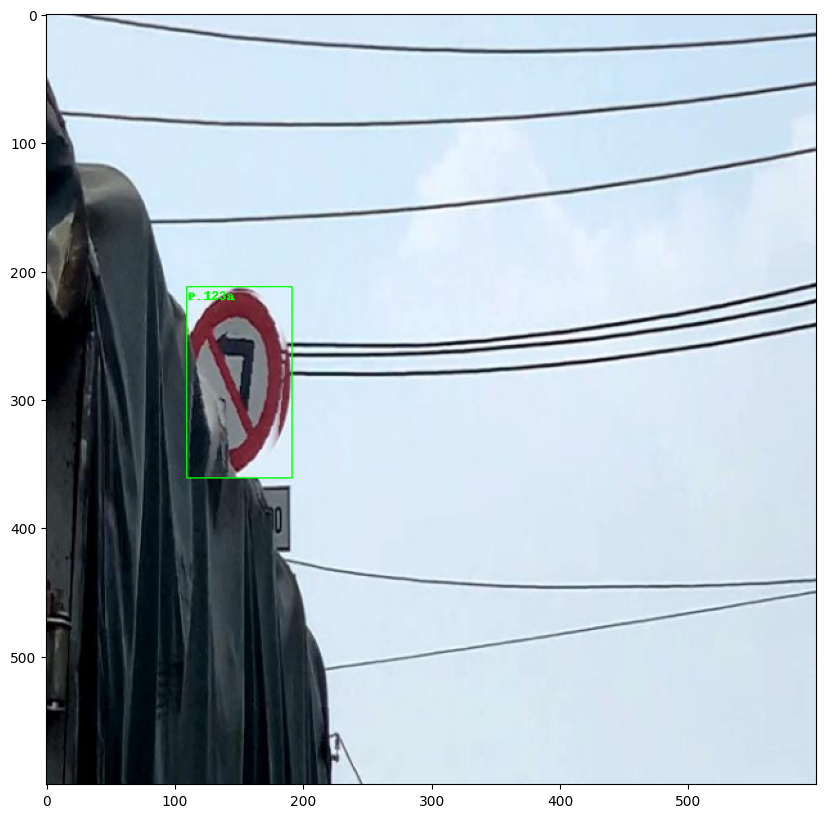

In [ ]:
# Lets view a sample
fig = plt.figure(figsize=(14, 10))
sample = train_dataset[1]
img_int = torch.tensor(sample[0] * 255, dtype=torch.uint8)
plt.imshow(draw_bounding_boxes(
    img_int, sample[1]['boxes'], [classes[i] for i in sample[1]['labels']], width=1,
    colors=[(0,255,0)] * 10
).permute(1, 2, 0))

In [ ]:
len(train_dataset)

9071

## Model

Our model is FasterRCNN with a backbone of `MobileNetV3-Large`. We need to change the output layers because we have just 7 classes but this model was trained on 90 classes.

In [ ]:
# lets load the faster rcnn model
model = models.detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained=False)
in_features = model.roi_heads.box_predictor.cls_score.in_features # we need to change the head
model.roi_heads.box_predictor = models.detection.faster_rcnn.FastRCNNPredictor(in_features, n_classes)

Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-8738ca79.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-8738ca79.pth
100%|██████████| 21.1M/21.1M [00:00<00:00, 122MB/s] 


This is our collating function for the train dataloader, it allows us to create batches of data that can be easily pass into the model

In [ ]:
load_model = False

In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4, collate_fn=collate_fn)

The following blocks ensures that the model can take in the data and that it will not crash during training

In [ ]:
images,targets = next(iter(train_loader))
images = list(image for image in images)
targets = [{k:v for k, v in t.items()} for t in targets]
output = model(images, targets) # just make sure this runs without error

In [ ]:
device = torch.device("cuda") # use GPU to train

In [ ]:
model = model.to(device)

## Optimizer

Here, we define the optimizer. If you wish, you can also define the LR Scheduler, but it is not necessary for this notebook since our dataset is so small.

> Note, there are a few bugs with the current way `lr_scheduler` is implemented. If you wish to use the scheduler, you will have to fix those bugs

In [ ]:
# Now, and optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9, nesterov=True, weight_decay=1e-4)
# lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[16, 22], gamma=0.1) # lr scheduler

In [ ]:
import sys

## Training

The following is a function that will train the model for one epoch. Torchvision Object Detections models have a loss function built in, and it will calculate the loss automatically if you pass in the `inputs` and `targets`

set up wandb

In [ ]:
if not load_model:
    !pip install wandb
    import wandb
    wandb.login(key='e3ad23ed51051c398718b486c705986cd6e461cd')
    # start a new wandb run to track this script
    wandb.init(
        # set the wandb project where this run will be logged
        project="FASTER-RCNN",

        # track hyperparameters and run metadata
        config={
        "learning_rate": 0.001,
        "architecture": "FASTER R-CNN",
        "dataset": "Custom",
        "epochs": 100,
        }
)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 22.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.1/254.1 kB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.0 MB/s eta 0:00:00


wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: thaivo02 (hung10032002). Use `wandb login --relogin` to force relogin


In [ ]:
def train_one_epoch(model, optimizer, loader, device, epoch):
    model.to(device)
    model.train()

#     lr_scheduler = None
#     if epoch == 0:
#         warmup_factor = 1.0 / 1000 # do lr warmup
#         warmup_iters = min(1000, len(loader) - 1)

#         lr_scheduler = optim.lr_scheduler.LinearLR(optimizer, start_factor = warmup_factor, total_iters=warmup_iters)

    all_losses = []
    all_losses_dict = []

    for images, targets in tqdm(loader):
        images = list(image.to(device) for image in images)
        targets = [{k: torch.tensor(v).to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets) # the model computes the loss automatically if we pass in targets
        losses = sum(loss for loss in loss_dict.values())
        loss_dict_append = {k: v.item() for k, v in loss_dict.items()}
        loss_value = losses.item()

        all_losses.append(loss_value)
        all_losses_dict.append(loss_dict_append)

        if not math.isfinite(loss_value):
            print(f"Loss is {loss_value}, stopping trainig") # train if loss becomes infinity
            print(loss_dict)
            sys.exit(1)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

#         if lr_scheduler is not None:
#             lr_scheduler.step() #

    all_losses_dict = pd.DataFrame(all_losses_dict) # for printing
    wandb.log({"all_losses_dict": all_losses_dict})
    print("Epoch {}, lr: {:.6f}, loss: {:.6f}, loss_classifier: {:.6f}, loss_box: {:.6f}, loss_rpn_box: {:.6f}, loss_object: {:.6f}".format(
        epoch, optimizer.param_groups[0]['lr'], np.mean(all_losses),
        all_losses_dict['loss_classifier'].mean(),
        all_losses_dict['loss_box_reg'].mean(),
        all_losses_dict['loss_rpn_box_reg'].mean(),
        all_losses_dict['loss_objectness'].mean()
    ))

10 Epochs should be enough to train this model for a high accuracy

In [ ]:
# Magic
num_epochs=100
model_name = "final_model.pth"
if not load_model:
    wandb.watch(model, log_freq=100)
    for epoch in range(num_epochs):
        train_one_epoch(model, optimizer, train_loader, device, epoch)
    torch.save(model, model_name)
    #     lr_scheduler.step()

100%|██████████| 2268/2268 [07:12<00:00,  5.24it/s]


Epoch 0, lr: 0.001000, loss: 0.317400, loss_classifier: 0.155752, loss_box: 0.099722, loss_rpn_box: 0.012549, loss_object: 0.049377


In [ ]:
# our learning rate was too low, due to a lr scheduler bug. For this task, we wont need a scheudul.er

## Trying on sample Images

This is the inference code for the model. First, we set the model to evaluation mode and clear the GPU Cache. We also load a test dataset, so that we can use fresh images that the model hasn't seen.

In [ ]:
# we will watch first epoich to ensure no errrors
# while it is training, lets write code to see the models predictions. lets try again
model.eval()
torch.cuda.empty_cache()

Checkpoint

In [ ]:
if load_model:
    checkpoint = "/content/lastcheckpoint/last_checkpoint.pth"
    checkpoint = torch.load(checkpoint)
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])

# Test ảnh trên tập test

In [ ]:
test_dataset = SignDetection(root=dataset_path, split="test", transforms=get_transforms(False))
len(test_dataset)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


481

In [ ]:
custom_test = False
import time
start = time.time()
if custom_test:
    test_path = ""

In [ ]:
if not custom_test:
    start = time.time()
    img, _ = test_dataset[0]
    img_int = torch.tensor(img*255, dtype=torch.uint8)
    with torch.no_grad():
        prediction = model([img.to(device)])
        pred = prediction[0]
    pred

Dự đoán dạng Tensor

In [ ]:
def custom_predict(path):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    transform = T.ToTensor()
    image = transform(image)
    return image

In [ ]:
if custom_test:
    img = custom_predict(test_path)
    img_int = torch.tensor(img*255, dtype=torch.uint8)
    # img_list = [t.to(device) for t in img_list]
    with torch.no_grad():
        predictions = model([img.to(device)])
        pred = predictions[0]
    pred

Chuyển frame thành dạng Tensor

In [ ]:
def custom_frame(frame):
    image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    transform = T.ToTensor()
    image = transform(image)
    return image

In [ ]:
threshold = 0

Vẽ bounding box

In [ ]:
def draw_frame(frame, pred):
    x1 = int(pred['boxes'][pred['scores'] >= threshold][0,0].tolist())
    x2 = int(pred['boxes'][pred['scores'] >= threshold][0,1].tolist())
    x3 = int(pred['boxes'][pred['scores'] >= threshold][0,2].tolist())
    x4 = int(pred['boxes'][pred['scores'] >= threshold][0,3].tolist())
    top_probability = max(pred["scores"]).item()
    labels = pred['labels'][pred['scores'] == top_probability]
    top_probability = '%.2f%%' % (top_probability * 100)
    label = [classes[i] for i in labels.tolist()][0]

    color = (255,192,203)
#     frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frame = cv2.rectangle(frame, (x1, x2), (x3, x4), color, 2)
    frame = cv2.rectangle(frame, (x1 - 60, x2 - 25), (x1 + 85, x2 - 5), color, -1)
    frame = cv2.putText(frame, label+': '+top_probability, (x1 - 60, x2 - 10), 2 , 0.5, (255, 255, 255), 2)

    return frame

In [ ]:
if custom_test:
    import torch.nn.functional as F
    videoCapture = cv2.VideoCapture("")
    fps = videoCapture.get(cv2.CAP_PROP_FPS)
    size = (int(videoCapture.get(cv2.CAP_PROP_FRAME_WIDTH)), int(videoCapture.get(cv2.CAP_PROP_FRAME_HEIGHT)))
#     ps = 25
    fourcc = cv2.VideoWriter_fourcc('M','J','P','G')
#     videoWriter = cv2.VideoWriter(r"output.mp4", fourcc, fps, size)
    videoWriter = cv2.VideoWriter('output.avi', fourcc, fps, size)
    with torch.no_grad():
        success, frame = videoCapture.read()
        while success:
            plt.imshow(frame)
            frame_copy = copy.deepcopy(frame)
            image_tensor = custom_frame(frame_copy)
            img_int = torch.tensor(image_tensor*255, dtype=torch.uint8)
            predictions = model([image_tensor.to(device)])
            pred = predictions[0]
            draw_bounding_boxes(img_int,
            pred['boxes'][pred['scores'] >= threshold],
                [classes[i] for i in pred['labels'][pred['scores'] >= threshold].tolist()], width=1,
                colors=[(0,255,0)] * 10,
                fill =True)
            if len(pred["scores"]) > 0:
#                 top_probability = max(pred["scores"]).item()
#                 labels = pred['labels'][pred['scores'] == top_probability]
#                 top_probability = '%.2f%%' % (top_probability * 100)
#                 label = [classes[i] for i in labels.tolist()][0]
#                 frame = cv2.putText(frame, label+': '+top_probability, (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 0, 255), 2)
                frame = draw_frame(frame, pred)
            videoWriter.write(frame)
            success, frame = videoCapture.read()
        videoWriter.release()

Vẽ ảnh vừa test

0.44409704208374023


['P.131a']

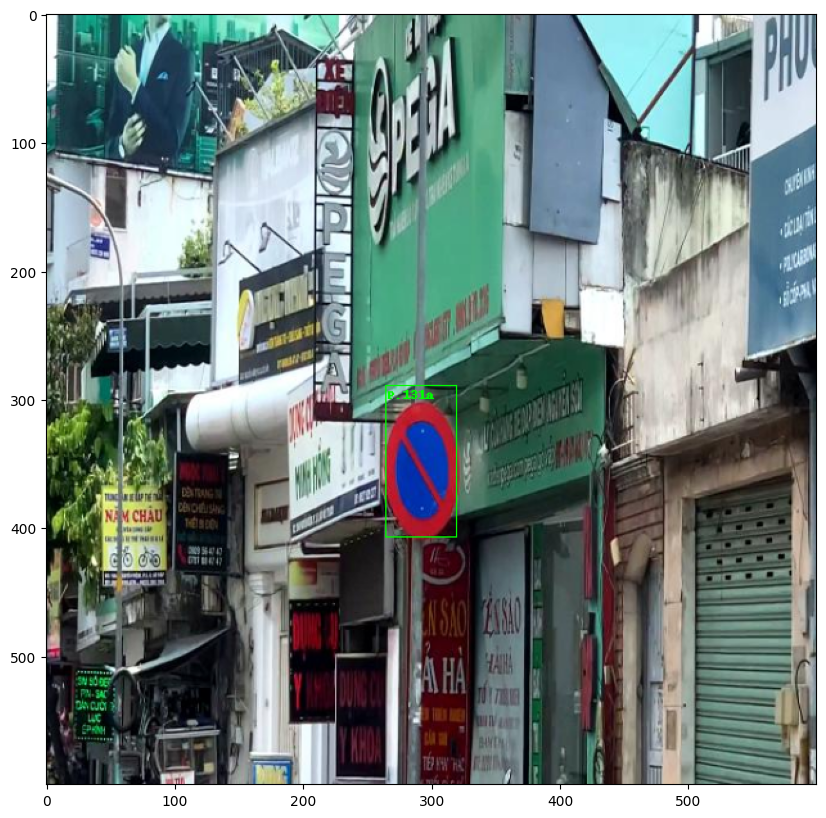

In [ ]:
fig = plt.figure(figsize=(14, 10))
plt.imshow(draw_bounding_boxes(img_int,
    pred['boxes'][pred['scores'] >= threshold],
    [classes[i] for i in pred['labels'][pred['scores'] >= threshold].tolist()], width=1,
    colors=[(0,255,0)] * 10,
#     fill =True
).permute(1, 2, 0))
end = time.time()
print(end - start)
plt.savefig('output.png')
[classes[i] for i in pred['labels'][pred['scores'] > 0].tolist()]

# Test video

In [ ]:
import cv2
import torch
from torchvision.utils import draw_bounding_boxes

# Load the pre-trained model and set it to evaluation mode
model_path  = '/content/final_model.pth'  # Your trained Faster R-CNN model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = torch.load(model_path)
model = model.to(device)
model.eval()

# Video paths
video_path = '/content/video6.mp4'
output_path = '/content/output6.mp4'

# Open the video file
video = cv2.VideoCapture(video_path)
width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter(output_path, fourcc, 20.0, (width, height))

while True:
    ret, frame = video.read()

    if not ret:
        break  # Break the loop if no frames are read

    # Convert frame to tensor and perform object detection
    img_tensor = torch.tensor(frame, dtype=torch.float32).permute(2, 0, 1) / 255.0
    img_tensor = img_tensor.unsqueeze(0).to(device)  # Add batch dimension and move to GPU

    with torch.no_grad():
        prediction = model(img_tensor)
        pred = prediction[0]

    # Draw bounding boxes on the frame based on predictions
    annotated_frame = draw_bounding_boxes(
        torch.tensor(frame, dtype=torch.uint8).permute(2, 0, 1),
        pred['boxes'][pred['scores'] > 0.8],
        [classes[i] for i in pred['labels'][pred['scores'] > 0.8].tolist()],
        width=4
    ).permute(1, 2, 0)

    # Write the annotated frame to the output video
    out.write(annotated_frame.numpy())

# Release the VideoCapture and VideoWriter objects
video.release()
out.release()
